In [62]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import plotly.express as px
import ast
import re
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from matplotlib.gridspec import GridSpec

Following Cells are for formatting the cewll content

In [63]:
# This turns strings in the CSV file into tuples
def convert_to_tuple(x):
    if type(x) != float:
        if x[0] == '(':
            x = x.replace('tensor','')
            y = re.sub(r"[()]","",x)
            return eval(y)
        else:
            return x
    else:
        return x

def convert_to_int(x):
    try:
        return int(x)
    except:
        return x

# Extracts the Bert F1 score from the tuple
def get_Bert_F1(x):
    try:
        return x[2]
    except:
        return x

def get_template_num(x):
    if x[-1].isdigit():
        return x[-2:]
    else:
        return 0

def string_to_tuple(x):
    x = x.strip('[]')
    x_list = x.split()
    return tuple(map(float, x_list))
    


In [64]:
#Define the table for the metric summaries
all_metric_summaries = pd.DataFrame(columns=['Type', 'Avg BertScore', 'Std Bert', 'Max Bert', 'CQ Max Bert',
       'Min Bert', 'CQ Min Bert', 'Bert Quartiles', 'Avg Meteor', 'Max Meteor',
       'Min Meteor', 'Std Meteor', 'CQ Max Meteor', 'CQ Min Meteor',
       'Meteor Quartiles', 'Avg chrF', 'Max chrF', 'Min chrF', 'Std chrF',
       'CQ Max chrF', 'CQ Min chrF', 'chrF Quartiles', 'Avg Rouge F1',
       'Rouge std F1', 'Max Rouge F1', 'CQ Max Rouge F1', 'Min Rouge F1',
       'Worst CQ F1', 'Rouge Quartiles F1'])
for filename in os.listdir('all_metric_summmaries'):
    data = pd.read_csv(f'all_metric_summmaries/{filename}',index_col=0)
    all_metric_summaries = pd.concat([all_metric_summaries,data],ignore_index=True)

for column in all_metric_summaries.columns:
    all_metric_summaries[column] = all_metric_summaries[column].apply(convert_to_tuple)

all_metric_summaries['Num Templates'] = all_metric_summaries['Type'].apply(get_template_num)
all_metric_summaries['Num Templates'] = all_metric_summaries['Num Templates'].apply(convert_to_int)
all_metric_summaries = all_metric_summaries.drop(columns=['Avg Metoer'])
all_metric_summaries['Rouge Quartiles F1'] = all_metric_summaries['Rouge Quartiles F1'].apply(string_to_tuple)


C:\Users\willi\AppData\Local\Temp\ipykernel_17128\899202632.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_metric_summaries = pd.concat([all_metric_summaries,data],ignore_index=True)


In [65]:
all_metric_summaries['Avg Bert F1'] = all_metric_summaries['Avg BertScore'].apply(get_Bert_F1)
all_metric_summaries['Std Bert F1'] = all_metric_summaries['Std Bert'].apply(get_Bert_F1)
all_metric_summaries['Max Bert F1'] = all_metric_summaries['Max Bert'].apply(get_Bert_F1)
all_metric_summaries['Sum Metrics'] = all_metric_summaries['Avg Bert F1']/all_metric_summaries['Std Bert F1'] + all_metric_summaries['Avg chrF']/(100*all_metric_summaries['Std chrF']) + all_metric_summaries['Avg Meteor']/all_metric_summaries['Std Meteor']
all_metric_summaries.to_csv('all_metric_summaries.csv')

In [66]:
# Here we extract the model name from the type to make plotting by each model easier
def extract_model(x):
    models = ['flan-base', 'flan-large','pythia','Llama']
    for model in models:
        if model in x:
            return model
        
all_metric_summaries['Model'] = all_metric_summaries['Type'].apply(extract_model)

# Here we add an order in which we want to plot our prompting techniques
def add_order(x):
    methods = ['Zero Shot','Few Shot Good', 'Few Shot Good and Bad','Filling Chunks with LOV', 'Filling Examples','Using Chunks','Using Triples']
    for method in methods:
        if method in x:
            if method == 'Zero Shot':
                return 0
            elif method == 'Few Shot Good' and 'Bad' not in x:
                return 1
            elif method == 'Few Shot Good and Bad':
                return 2
            elif method == 'Filling Chunks with LOV':
                return 3
            elif method == 'Filling Examples':
                return 4
            elif method == 'Using Chunks':
                return 5
            elif method == 'Using Triples':
                return 6

all_metric_summaries['Order'] = all_metric_summaries['Type'].apply(add_order)   

# The following to chunks of code splits the data further so that individual models or prompting techniques are more accessible.
metric_results = {}
methods = ['Zero Shot','Few Shot Good', 'Few Shot Good and Bad','Filling Chunks with LOV', 'Filling Examples','Using Chunks','Using Triples','LOV','ROH']
ends = ['flan-base', 'flan-large','pythia','Llama']
template_nos = [1,5,10,15,20,25]
syntax_results = {}
syntax_results_template_no = {}
for method in methods:
    metric_results[method] = all_metric_summaries[all_metric_summaries['Type'].str.contains(method)]
    metric_results[method] = metric_results[method].reset_index(drop=True)

drops = metric_results['Few Shot Good'][metric_results['Few Shot Good']['Type'].str.contains('Bad')].index
metric_results['Few Shot Good'] = metric_results['Few Shot Good'].drop(drops).reset_index(drop=True)

models = ['flan-base', 'flan-large','pythia','Llama']
split_results = {}
split_results['LOV'] = all_metric_summaries[all_metric_summaries['Type'] == 'LOV'].reset_index(drop=True)
for key in metric_results.keys():
    if key != 'LOV':
        split_results[key] = {}
        for model in models:
            split_results[key][model] = metric_results[key][metric_results[key]['Type'].str.contains(model)].sort_values(by='Num Templates').reset_index(drop=True)


The effect of different prompting techniques on each model

['LOV', 'Zero Shot Llama', 'Zero Shot', 'Few Shot Good', 'Few Shot Good and Bad', 'Filling Chunks with LOV', 'Filling Examples', 'Using Chunks', 'Using Triples']


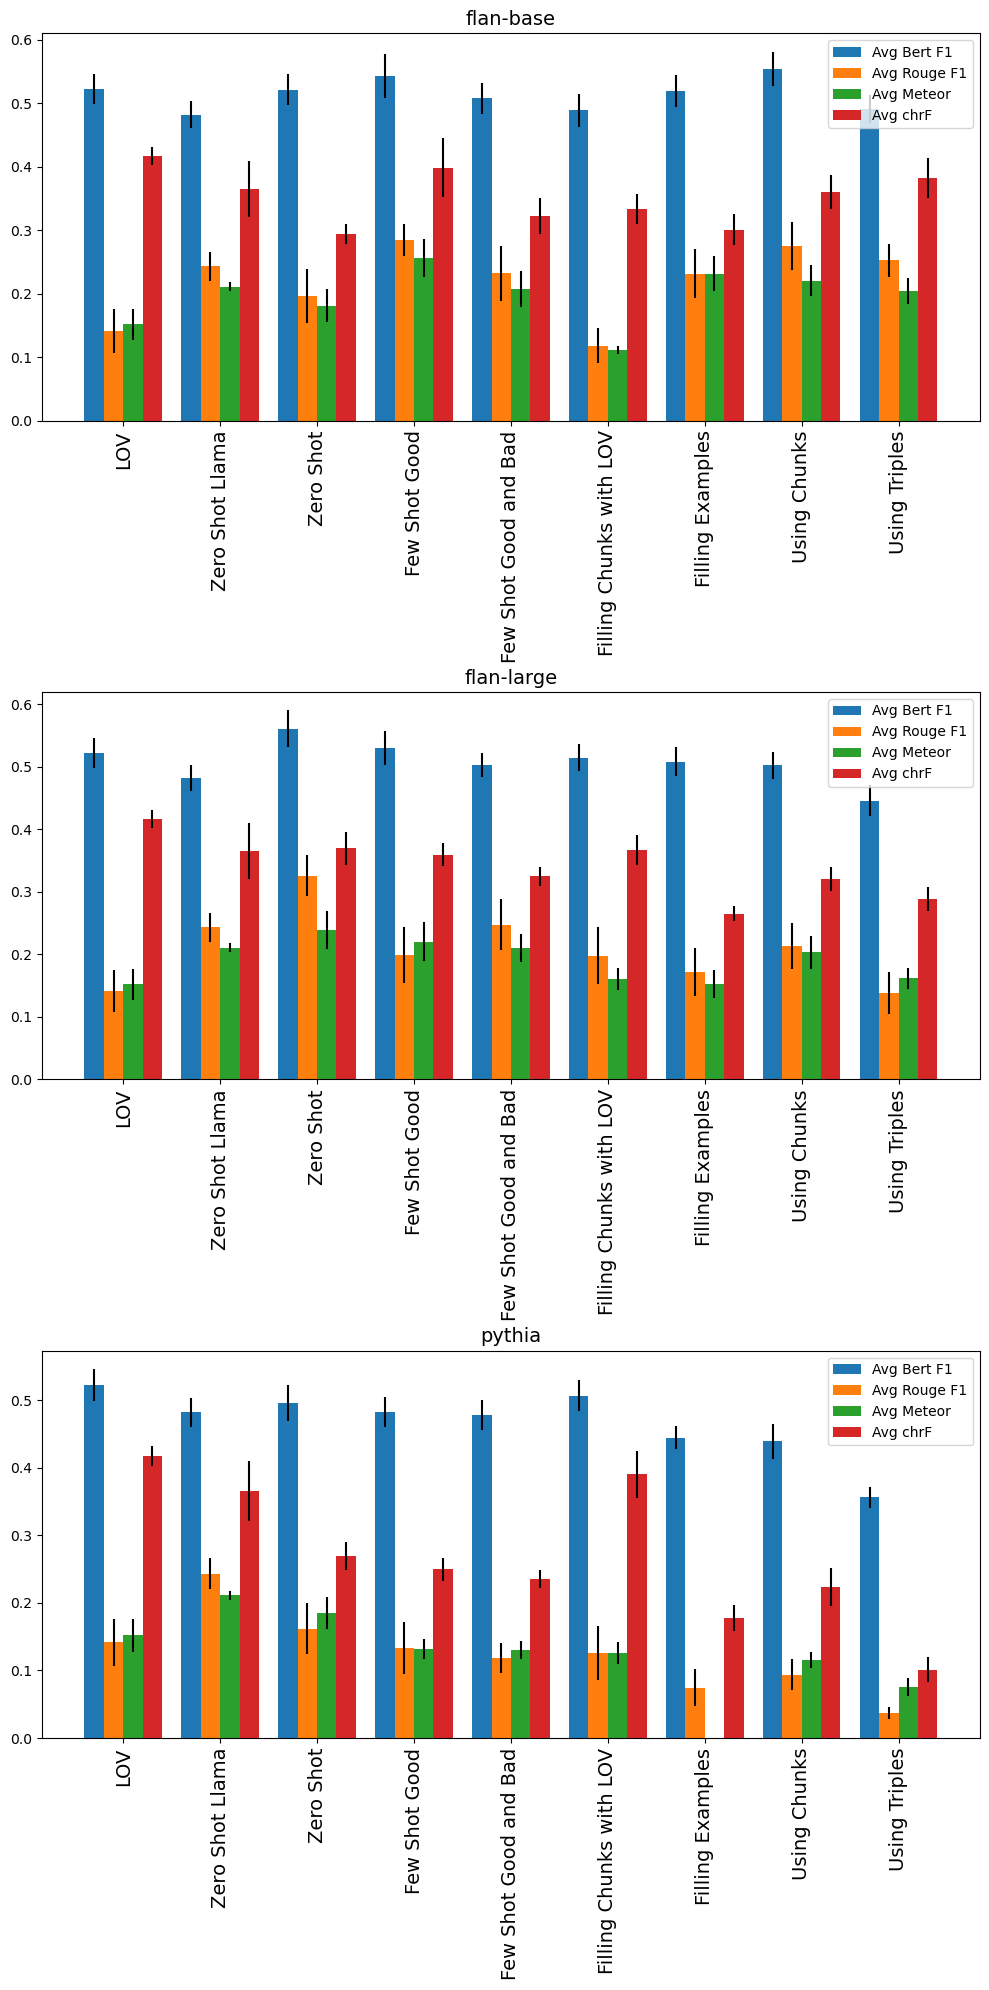

<Figure size 640x480 with 0 Axes>

In [68]:
df = all_metric_summaries[all_metric_summaries['Num Templates']==10].reset_index(drop=True)
methods = ['LOV','Zero Shot Llama','Zero Shot','Few Shot Good', 'Few Shot Good and Bad','Filling Chunks with LOV', 'Filling Examples','Using Chunks','Using Triples']
flan_base = pd.concat([split_results['LOV'],split_results['Zero Shot']['Llama'], split_results['Zero Shot']['flan-base'],df[df['Model'] == 'flan-base']])
flan_large = pd.concat([split_results['LOV'],split_results['Zero Shot']['Llama'], split_results['Zero Shot']['flan-large'], df[df['Model'] == 'flan-large']])
pythia = pd.concat([split_results['LOV'],split_results['Zero Shot']['Llama'], split_results['Zero Shot']['pythia'], df[df['Model'] == 'pythia']])
x = np.arange(len(methods))
fig, axes = plt.subplots(3, 1, figsize=(10, 20))
width = 0.2
axes[0].bar(x-0.3, flan_base['Avg Bert F1'], width, yerr= flan_base['Std Bert F1']/sqrt(10),label='Avg Bert F1')
axes[0].bar(x-0.1, flan_base['Avg Rouge F1'], width, yerr= flan_base['Rouge std F1']/sqrt(10),label='Avg Rouge F1')
axes[0].bar(x+0.1, flan_base['Avg Meteor'], width, yerr= flan_base['Std Meteor']/sqrt(10),label='Avg Meteor')
axes[0].bar(x+0.3, flan_base['Avg chrF']/100, width, yerr= flan_base['Std chrF']/(100*sqrt(10)),label='Avg chrF')

axes[1].bar(x-0.3, flan_large['Avg Bert F1'], width, yerr= flan_large['Std Bert F1']/sqrt(10),label='Avg Bert F1')
axes[1].bar(x-0.1, flan_large['Avg Rouge F1'], width, yerr= flan_large['Rouge std F1']/sqrt(10),label='Avg Rouge F1')
axes[1].bar(x+0.1, flan_large['Avg Meteor'], width, yerr= flan_large['Std Meteor']/sqrt(10),label='Avg Meteor')
axes[1].bar(x+0.3, flan_large['Avg chrF']/100, width, yerr= flan_large['Std chrF']/(100*sqrt(10)),label='Avg chrF')

axes[2].bar(x-0.3, pythia['Avg Bert F1'], width, yerr= pythia['Std Bert F1']/sqrt(10),label='Avg Bert F1')
axes[2].bar(x-0.1, pythia['Avg Rouge F1'], width, yerr= pythia['Rouge std F1']/sqrt(10),label='Avg Rouge F1')
axes[2].bar(x+0.1, pythia['Avg Meteor'], width, yerr= pythia['Std Meteor']/sqrt(10),label='Avg Meteor')
axes[2].bar(x+0.3, pythia['Avg chrF']/100, width, yerr= pythia['Std chrF']/(100*sqrt(10)),label='Avg chrF')

methods = ['LOV','Zero Shot Llama','Zero Shot','Few Shot Good', 'Few Shot Good and Bad','Filling Chunks with LOV', 'Filling Examples','Using Chunks','Using Triples']
print(methods)

axes[0].set_title('flan-base',fontsize = 14)
axes[1].set_title('flan-large',fontsize = 14)
axes[2].set_title('pythia',fontsize = 14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods, rotation=90,fontsize = 14)
axes[1].set_xticks(x)
axes[1].set_xticklabels(methods, rotation=90,fontsize = 14)
axes[2].set_xticks(x)
axes[2].set_xticklabels(methods, rotation=90,fontsize = 14)

axes[0].legend()
axes[1].legend()
axes[2].legend()

plt.tight_layout()
plt.subplots_adjust(hspace=0.7)
plt.show()
plt.savefig('plots/model_comparison all templates splt.png')


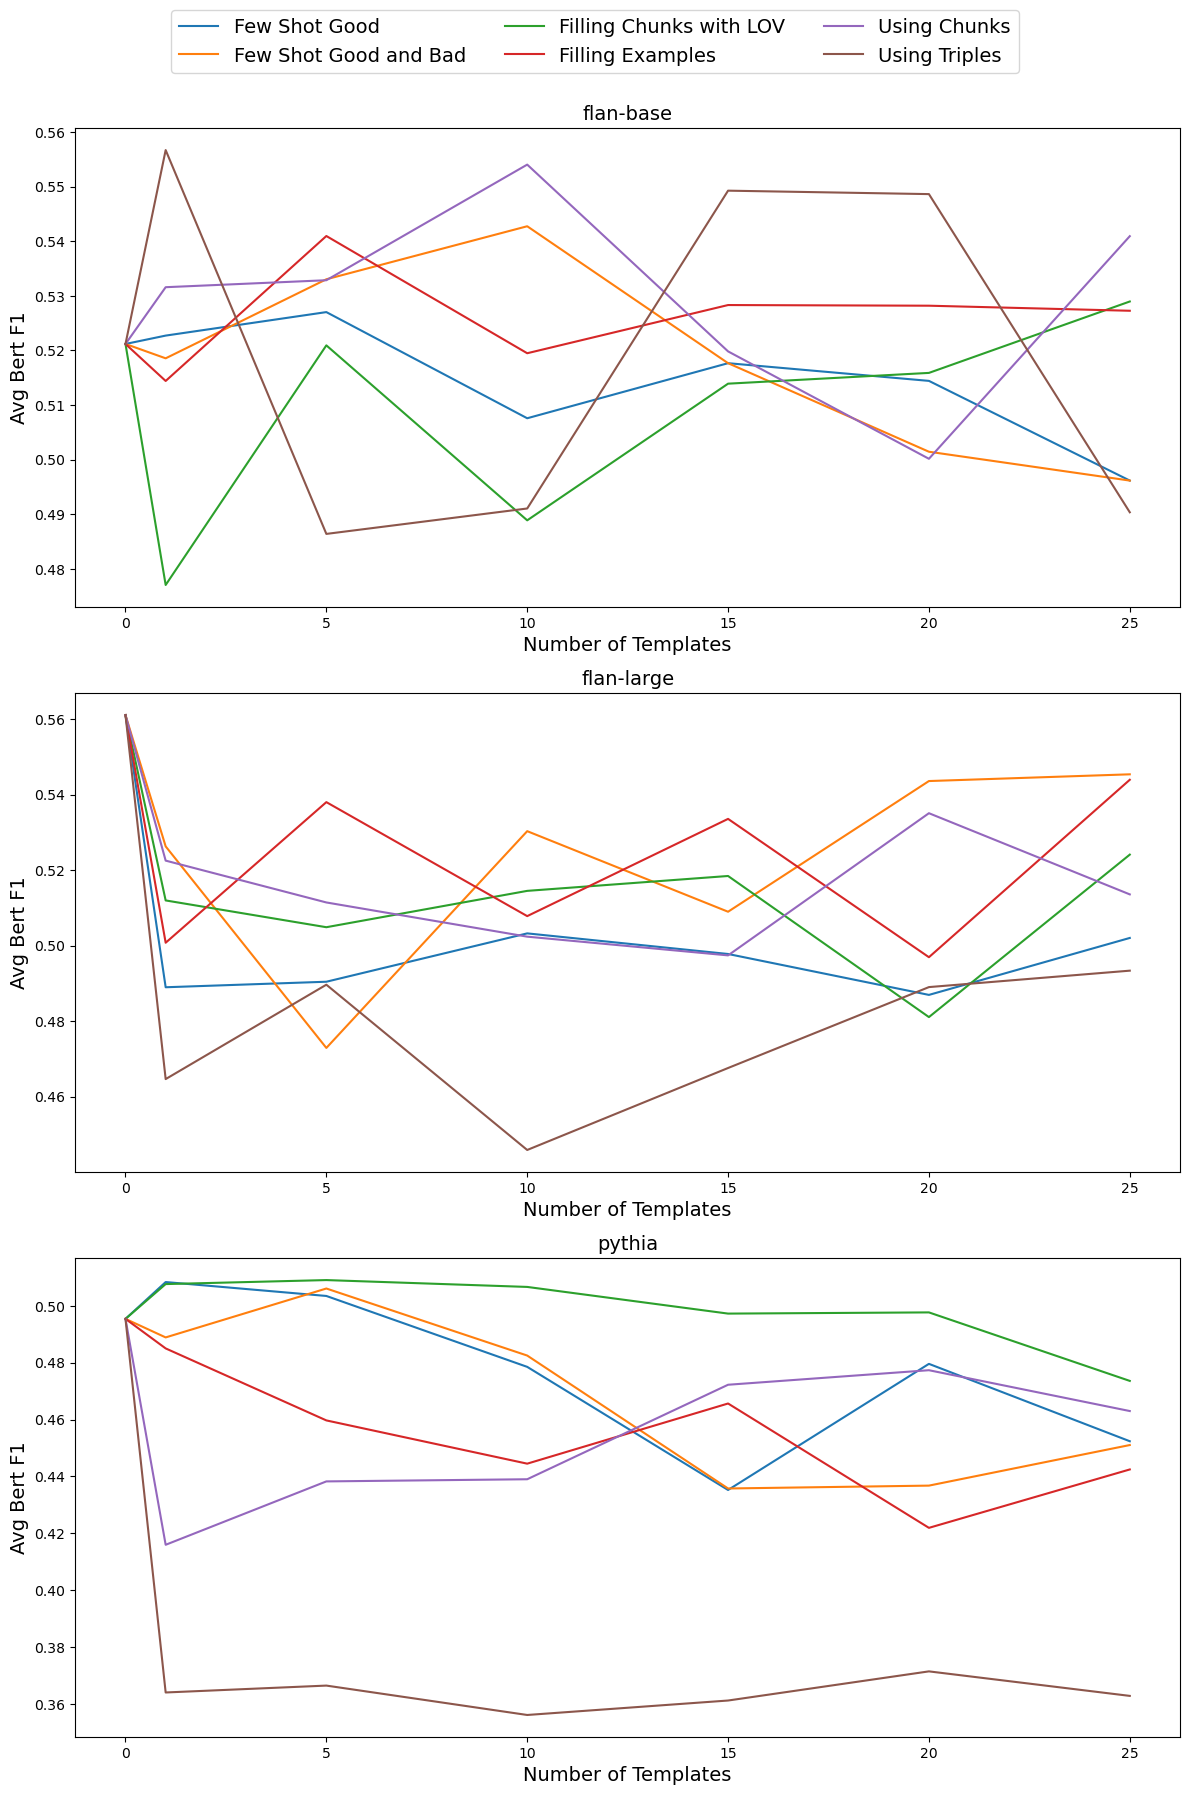

In [69]:
# A function to draw a stacked line graph showing the effect of examples on a metric for each model
def stacked_line_charts(metric):   
    flan_base_few_shot_good = split_results['Zero Shot']['flan-base'][metric].tolist()
    flan_base_few_shot_good.extend(split_results['Few Shot Good']['flan-base'][metric].tolist())
    flan_base_few_shot_good_and_bad = split_results['Zero Shot']['flan-base'][metric].tolist()
    flan_base_few_shot_good_and_bad.extend(split_results['Few Shot Good and Bad']['flan-base'][metric].tolist())
    flan_base_filling_chunks_with_LOV = split_results['Zero Shot']['flan-base'][metric].tolist()
    flan_base_filling_chunks_with_LOV.extend(split_results['Filling Chunks with LOV']['flan-base'][metric].tolist())
    flan_base_filling_examples = split_results['Zero Shot']['flan-base'][metric].tolist()
    flan_base_filling_examples.extend(split_results['Filling Examples']['flan-base'][metric].tolist())
    flan_base_using_chunks = split_results['Zero Shot']['flan-base'][metric].tolist()
    flan_base_using_chunks.extend(split_results['Using Chunks']['flan-base'][metric].tolist())
    flan_base_using_triples = split_results['Zero Shot']['flan-base'][metric].tolist()
    flan_base_using_triples.extend(split_results['Using Triples']['flan-base'][metric].tolist())

    flan_large_few_shot_good = split_results['Zero Shot']['flan-large'][metric].tolist()
    flan_large_few_shot_good.extend(split_results['Few Shot Good']['flan-large'][metric].tolist())
    flan_large_few_shot_good_and_bad = split_results['Zero Shot']['flan-large'][metric].tolist()
    flan_large_few_shot_good_and_bad.extend(split_results['Few Shot Good and Bad']['flan-large'][metric].tolist())
    flan_large_filling_chunks_with_LOV = split_results['Zero Shot']['flan-large'][metric].tolist()
    flan_large_filling_chunks_with_LOV.extend(split_results['Filling Chunks with LOV']['flan-large'][metric].tolist())
    flan_large_filling_examples = split_results['Zero Shot']['flan-large'][metric].tolist()
    flan_large_filling_examples.extend(split_results['Filling Examples']['flan-large'][metric].tolist())
    flan_large_using_chunks = split_results['Zero Shot']['flan-large'][metric].tolist()
    flan_large_using_chunks.extend(split_results['Using Chunks']['flan-large'][metric].tolist())
    flan_large_using_triples = split_results['Zero Shot']['flan-large'][metric].tolist()
    flan_large_using_triples.extend(split_results['Using Triples']['flan-large'][metric].tolist())

    pythia_few_shot_good = split_results['Zero Shot']['pythia'][metric].tolist()
    pythia_few_shot_good.extend(split_results['Few Shot Good']['pythia'][metric].tolist())
    pythia_few_shot_good_and_bad = split_results['Zero Shot']['pythia'][metric].tolist()
    pythia_few_shot_good_and_bad.extend(split_results['Few Shot Good and Bad']['pythia'][metric].tolist())
    pythia_filling_chunks_with_LOV = split_results['Zero Shot']['pythia'][metric].tolist()
    pythia_filling_chunks_with_LOV.extend(split_results['Filling Chunks with LOV']['pythia'][metric].tolist())
    pythia_filling_examples = split_results['Zero Shot']['pythia'][metric].tolist()
    pythia_filling_examples.extend(split_results['Filling Examples']['pythia'][metric].tolist())
    pythia_using_chunks = split_results['Zero Shot']['pythia'][metric].tolist()
    pythia_using_chunks.extend(split_results['Using Chunks']['pythia'][metric].tolist())
    pythia_using_triples = split_results['Zero Shot']['pythia'][metric].tolist()
    pythia_using_triples.extend(split_results['Using Triples']['pythia'][metric].tolist())
    # Produce datasets to be plortted for each model
    datasets = {
        'flan-base': {
            'Few Shot Good': flan_base_few_shot_good,
            'Few Shot Good and Bad': flan_base_few_shot_good_and_bad,
            'Filling Chunks with LOV': flan_base_filling_chunks_with_LOV,
            'Filling Examples': flan_base_filling_examples,
            'Using Chunks': flan_base_using_chunks,
            'Using Triples': flan_base_using_triples
        },
        'flan-large': {
            'Few Shot Good': flan_large_few_shot_good,
            'Few Shot Good and Bad': flan_large_few_shot_good_and_bad,
            'Filling Chunks with LOV': flan_large_filling_chunks_with_LOV,
            'Filling Examples': flan_large_filling_examples,
            'Using Chunks': flan_large_using_chunks,
            'Using Triples': flan_large_using_triples
        },
        'pythia': {
            'Few Shot Good': pythia_few_shot_good,
            'Few Shot Good and Bad': pythia_few_shot_good_and_bad,
            'Filling Chunks with LOV': pythia_filling_chunks_with_LOV,
            'Filling Examples': pythia_filling_examples,
            'Using Chunks': pythia_using_chunks,
            'Using Triples': pythia_using_triples
        }
    }
    x = [0,1,5,10,15,20,25]
    fig = plt.figure(figsize=(12, 18))
    gs = GridSpec(3, 1, figure=fig)

    # Define titles for the datasets
    titles = ['flan-base', 'flan-large', 'pythia']

    axes = []
    # Plot data for each dataset
    for i, (dataset_name, dataset) in enumerate(datasets.items()):
        ax = fig.add_subplot(gs[i, 0])
        for key, values in dataset.items():
            ax.plot(x, values, label=key)
        ax.set_ylabel(metric,fontsize = 14)
        ax.set_xlabel('Number of Templates',fontsize = 14)
        ax.set_title(titles[i],fontsize = 14)
        axes.append(ax)
    
    handles, labels = axes[-1].get_legend_handles_labels()
    # Create a single legend outside the subplots
    # Get the last axes' legend handles and labels

    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=3, fontsize = 14)

    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'plots/stacked plots showing effect of examples on {metric}.png')
    plt.show()

stacked_line_charts('Avg Bert F1')


The best model performers for each metric

In [70]:

x = all_metric_summaries.sort_values(by = 'Avg Bert F1',ascending=False).reset_index(drop=True)[:5]
top_bert_f1 = x[['Type','Avg Bert F1','Std Bert F1','Num Templates']]
top_bert_f1


,Type,Avg Bert F1,Std Bert F1,Num Templates
0,Zero Shot flan-large,0.561037,0.092571,0
1,Using Triples flan-base 1,0.556671,0.076219,1
2,Using Chunks flan-base 10,0.554012,0.085864,10
3,Using Triples flan-base 15,0.549241,0.077121,15
4,Using Triples flan-base 20,0.548612,0.093201,20


In [71]:
x = all_metric_summaries.sort_values(by = 'Avg chrF',ascending=False).reset_index(drop=True)[0:6]
top_avg_chrF = x[['Type','Avg chrF','Std chrF','Num Templates']]
top_avg_chrF

,Type,Avg chrF,Std chrF,Num Templates
0,Filling Chunks with LOV pythia-410m-deduped 20,42.598342,7.514664,20
1,Filling Examples flan-base 5,41.874374,6.862116,5
2,Filling Chunks with LOV flan-base 5,41.845632,5.499808,5
3,LOV,41.732005,4.555300,0
4,Using Triples flan-base 20,41.516110,10.195817,20
5,Using Triples flan-base 15,40.897430,6.619333,15


In [72]:
x = all_metric_summaries.sort_values(by = 'Avg Meteor',ascending=False).reset_index(drop=True)[:5]
top_avg_meteor = x[['Type','Avg Meteor','Std Meteor','Num Templates']]
top_avg_meteor

,Type,Avg Meteor,Std Meteor,Num Templates
0,Few Shot Good and Bad flan-base 10,0.256459,0.093669,10
1,Using Triples flan-large 5,0.252282,0.083293,5
2,Few Shot Good and Bad flan-large 1,0.238803,0.106010,1
3,Using Triples flan-base 20,0.238672,0.083803,20
4,Zero Shot flan-large,0.238445,0.095912,0


In [73]:
x = all_metric_summaries.sort_values(by = 'Avg Rouge F1',ascending=False).reset_index(drop=True)[:5]   
top_avg_rouge = x[['Type','Avg Rouge F1','Num Templates']]
top_avg_rouge

,Type,Avg Rouge F1,Num Templates
0,Zero Shot flan-large,0.326097,0
1,Using Triples flan-base 15,0.293309,15
2,Filling Examples flan-base 5,0.292643,5
3,Using Chunks flan-base 25,0.292288,25
4,Few Shot Good and Bad flan-base 10,0.285363,10


In [74]:
x = all_metric_summaries.sort_values(by = 'Avg Rouge F1',ascending=False).reset_index(drop=True)[:5]  
top_avg_rouge = x[['Type','Avg Rouge F1','Num Templates']]
top_avg_rouge

,Type,Avg Rouge F1,Num Templates
0,Zero Shot flan-large,0.326097,0
1,Using Triples flan-base 15,0.293309,15
2,Filling Examples flan-base 5,0.292643,5
3,Using Chunks flan-base 25,0.292288,25
4,Few Shot Good and Bad flan-base 10,0.285363,10


Metrics of each model in a zero shot setting

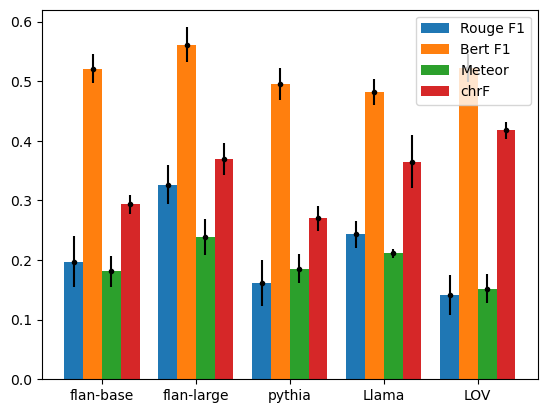

In [75]:
x = np.arange(5)
width = 0.2
y_rouge_f1 = [split_results['Zero Shot']['flan-base']['Avg Rouge F1'][0],split_results['Zero Shot']['flan-large']['Avg Rouge F1'][0],split_results['Zero Shot']['pythia']['Avg Rouge F1'][0],split_results['Zero Shot']['Llama']['Avg Rouge F1'][0],split_results['LOV']['Avg Rouge F1'][0]]
y_bert_f1 = [split_results['Zero Shot']['flan-base']['Avg Bert F1'][0],split_results['Zero Shot']['flan-large']['Avg Bert F1'][0],split_results['Zero Shot']['pythia']['Avg Bert F1'][0],split_results['Zero Shot']['Llama']['Avg Bert F1'][0],split_results['LOV']['Avg Bert F1'][0]]
y_meteor = [split_results['Zero Shot']['flan-base']['Avg Meteor'][0],split_results['Zero Shot']['flan-large']['Avg Meteor'][0],split_results['Zero Shot']['pythia']['Avg Meteor'][0],split_results['Zero Shot']['Llama']['Avg Meteor'][0],split_results['LOV']['Avg Meteor'][0]]
y_chrF = [split_results['Zero Shot']['flan-base']['Avg chrF'][0]/100,split_results['Zero Shot']['flan-large']['Avg chrF'][0]/100,split_results['Zero Shot']['pythia']['Avg chrF'][0]/100,split_results['Zero Shot']['Llama']['Avg chrF'][0]/100,split_results['LOV']['Avg chrF'][0]/100]
y_rouge_f1_std = [split_results['Zero Shot']['flan-base']['Rouge std F1'][0],split_results['Zero Shot']['flan-large']['Rouge std F1'][0],split_results['Zero Shot']['pythia']['Rouge std F1'][0],split_results['Zero Shot']['Llama']['Rouge std F1'][0],split_results['LOV']['Rouge std F1'][0]]
y_bert_f1_std = [split_results['Zero Shot']['flan-base']['Std Bert F1'][0],split_results['Zero Shot']['flan-large']['Std Bert F1'][0],split_results['Zero Shot']['pythia']['Std Bert F1'][0],split_results['Zero Shot']['Llama']['Std Bert F1'][0],split_results['LOV']['Std Bert F1'][0]]
y_meteor_std = [split_results['Zero Shot']['flan-base']['Std Meteor'][0],split_results['Zero Shot']['flan-large']['Std Meteor'][0],split_results['Zero Shot']['pythia']['Std Meteor'][0],split_results['Zero Shot']['Llama']['Std Meteor'][0],split_results['LOV']['Std Meteor'][0]]
y_chrF_std = [split_results['Zero Shot']['flan-base']['Std chrF'][0]/100,split_results['Zero Shot']['flan-large']['Std chrF'][0]/100,split_results['Zero Shot']['pythia']['Std chrF'][0]/100,split_results['Zero Shot']['Llama']['Std chrF'][0]/100,split_results['LOV']['Std chrF'][0]/100]
plt.bar(x-0.3,y_rouge_f1,width,label='Rouge F1')
plt.bar(x-0.1,y_bert_f1,width,label='Bert F1')
plt.bar(x+0.1,y_meteor,width,label='Meteor')
plt.bar(x+0.3,y_chrF,width,label='chrF')
plt.xticks(x, ['flan-base','flan-large','pythia','Llama','LOV'])
plt.errorbar(x-0.3,y_rouge_f1,yerr=[x/sqrt(10) for x in y_rouge_f1_std],fmt='.',color='black')
plt.errorbar(x-0.1,y_bert_f1,yerr=[x/sqrt(10) for x in y_bert_f1_std],fmt='.',color='black')
plt.errorbar(x+0.1,y_meteor,yerr=[x/sqrt(10) for x in y_meteor_std],fmt='.',color='black')
plt.errorbar(x+0.3,y_chrF,yerr=[x/sqrt(10) for x in y_chrF_std],fmt='.',color='black')
plt.legend()

Plot showing all of the prompting techniques for each model using ten examples

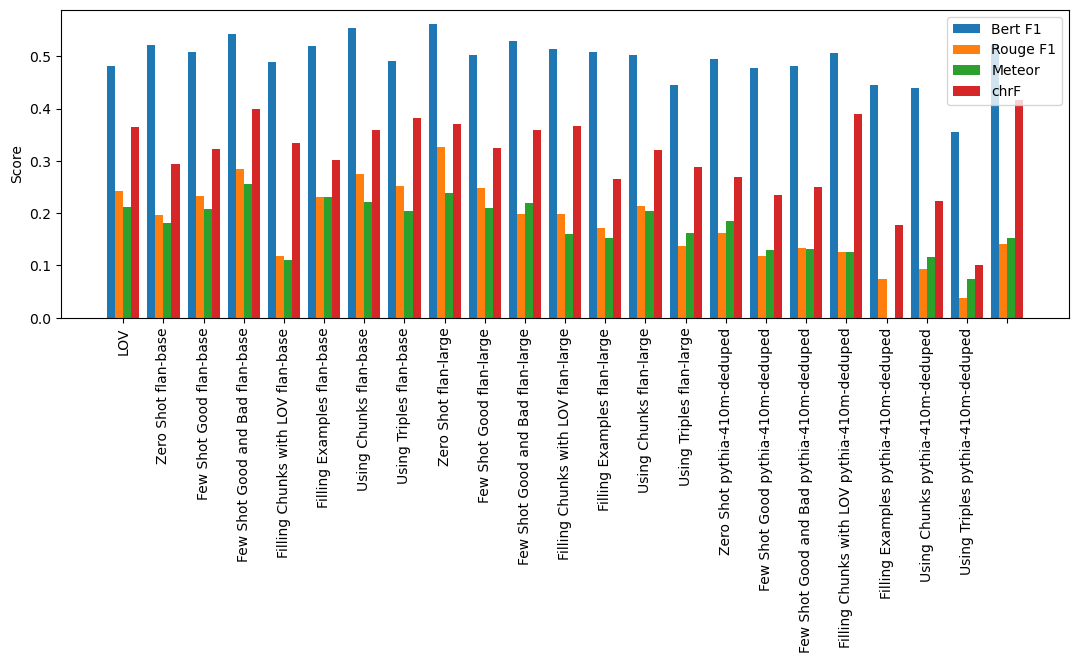

In [76]:
df = all_metric_summaries[all_metric_summaries['Num Templates'] == 10]
df = pd.concat([split_results['LOV'],split_results['Zero Shot']['Llama'],split_results['Zero Shot']['flan-base'],split_results['Zero Shot']['flan-large'],split_results['Zero Shot']['pythia'],df])
df = df.sort_values(['Model','Order'])
plt.figure(figsize=(13,4))
bert_f1_avg = df['Avg Bert F1']
rouge_f1_avg = df['Avg Rouge F1']
meteor_avg = df['Avg Meteor']
chrf_avg = df['Avg chrF']/100
bert_f1_std = df['Std Bert F1'].tolist()
rouge_f1_std = df['Rouge std F1'].tolist()
meteor_std = df['Std Meteor'].tolist()
chrf_std = df['Std chrF'].tolist()
x = np.arange(len(df))
width = 0.2
plt.bar(x-0.3,bert_f1_avg,width,label='Bert F1')
plt.bar(x-0.1,rouge_f1_avg,width,label='Rouge F1')
plt.bar(x+0.1,meteor_avg,width,label='Meteor')
plt.bar(x+0.3,chrf_avg,width,label='chrF')
#plt.errorbar(x-0.3,bert_f1_avg,yerr=[x/sqrt(10) for x in bert_f1_std],fmt='.',color='black')
#plt.errorbar(x-0.1,rouge_f1_avg,yerr=[x/sqrt(10) for x in rouge_f1_std],fmt='.',color='black')
#plt.errorbar(x+0.1,meteor_avg,yerr=[x/sqrt(10) for x in meteor_std],fmt='.',color='black')
#plt.errorbar(x+0.3,chrf_avg,yerr=[x/(100*sqrt(10)) for x in chrf_std],fmt='.',color='black')
xlabs = [x[:-3] if 'Zero' not in x else x for x in df['Type'].tolist()[1:]]
x_new = ['LOV']
x_new.extend(xlabs)
plt.xticks(x,x_new,rotation = 90 )
plt.ylabel('Score')
plt.legend()
plt.savefig('plots/all metric comparison',bbox_inches='tight')

Box Plot of the three best models

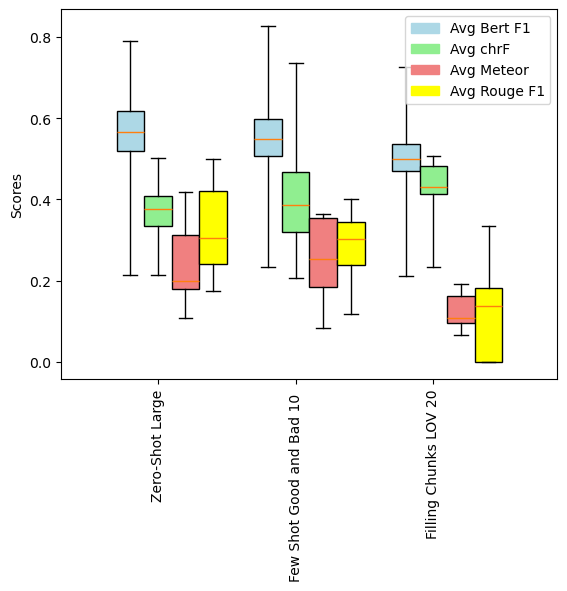

<Figure size 640x480 with 0 Axes>

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Define the boxplot statistics for two groups with two samples each
group1_stats = [
    {
        'label': 'G1-S1',
        'whislo': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['Min Bert'].reset_index(drop=True)[0][2],  # Bottom whisker (minimum value)
        'q1': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['Bert Quartiles'].reset_index(drop=True)[0][2],      # First quartile (Q1)
        'med': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['Bert Quartiles'].reset_index(drop=True)[0][5],     # Median (Q2)
        'q3': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['Bert Quartiles'].reset_index(drop=True)[0][8],      # Third quartile (Q3)
        'whishi': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['Max Bert'].reset_index(drop=True)[0][2],  # Top whisker (maximum value)
        'fliers': []   # Outliers, if any
    },
    {
        'label': 'G1-S2',
        'whislo': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['Min Bert'][0][2],  # Bottom whisker (minimum value)
        'q1': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['Bert Quartiles'][0][2],      # First quartile (Q1)
        'med': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['Bert Quartiles'][0][5],     # Median (Q2)
        'q3': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['Bert Quartiles'][0][8],      # Third quartile (Q3)
        'whishi': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['Max Bert'][0][2],  # Top whisker (maximum value)
        'fliers': []   # Outliers, if any
    },
    {
        'label': 'G1-S3',
        'whislo': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['Min Bert'][0][2],  # Bottom whisker (minimum value)
        'q1': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['Bert Quartiles'][0][2],      # First quartile (Q1)
        'med': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['Bert Quartiles'][0][5],     # Median (Q2)
        'q3': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['Bert Quartiles'][0][8],      # Third quartile (Q3)
        'whishi': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['Max Bert'][0][2],  # Top whisker (maximum value)
        'fliers': []   # Outliers, if any
    },
        
]

group2_stats = [
    {
        'label': 'G2-S1',
        'whislo': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['Min chrF'].reset_index(drop=True)[0]/100,  # Bottom whisker (minimum value)
        'q1': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['chrF Quartiles'].reset_index(drop=True)[0][0]/100,      # First quartile (Q1)
        'med': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['chrF Quartiles'].reset_index(drop=True)[0][1]/100,     # Median (Q2)
        'q3': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['chrF Quartiles'].reset_index(drop=True)[0][2]/100,      # Third quartile (Q3)
        'whishi': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['Max chrF'].reset_index(drop=True)[0]/100,  # Top whisker (maximum value)
        'fliers': []   # Outliers, if any
    },
    {
        'label': 'G2-S2',
        'whislo': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['Min chrF'][0]/100,  # Bottom whisker (minimum value)
        'q1': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['chrF Quartiles'][0][0]/100,      # First quartile (Q1)
        'med': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['chrF Quartiles'][0][1]/100,     # Median (Q2)
        'q3': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['chrF Quartiles'][0][2]/100,      # Third quartile (Q3)
        'whishi': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['Max chrF'][0]/100,  # Top whisker (maximum value)
        'fliers': []   # Outliers, if any
    },
    {
        'label': 'G2-S3',
        'whislo': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['Min chrF'][0]/100,  # Bottom whisker (minimum value)
        'q1': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['chrF Quartiles'][0][0]/100,      # First quartile (Q1)
        'med': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['chrF Quartiles'][0][1]/100,     # Median (Q2)
        'q3': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['chrF Quartiles'][0][2]/100,      # Third quartile (Q3)
        'whishi': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['Max chrF'][0]/100,  # Top whisker (maximum value)
        'fliers': []   # Outliers, if any
   
    }
]
group3_stats = [
    {
        'label': 'G3-S1',
        'whislo': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['Min Meteor'].reset_index(drop=True)[0],  # Bottom whisker (minimum value)
        'q1': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['Meteor Quartiles'].reset_index(drop=True)[0][0],      # First quartile (Q1)
        'med': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['Meteor Quartiles'].reset_index(drop=True)[0][1],     # Median (Q2)
        'q3': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['Meteor Quartiles'].reset_index(drop=True)[0][2],      # Third quartile (Q3)
        'whishi': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['Max Meteor'].reset_index(drop=True)[0],  # Top whisker (maximum value)
        'fliers': []   # Outliers, if any

    },
    {
        'label': 'G3-S2',
        'whislo': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['Min Meteor'][0],  # Bottom whisker (minimum value)
        'q1': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['Meteor Quartiles'][0][0],      # First quartile (Q1)
        'med': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['Meteor Quartiles'][0][1],     # Median (Q2)
        'q3': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['Meteor Quartiles'][0][2],      # Third quartile (Q3)
        'whishi': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['Max Meteor'][0],  # Top whisker (maximum value)
        'fliers': []   # Outliers, if any

    },
    {
        'label': 'G3-S3',
        'whislo': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['Min Meteor'][0],  # Bottom whisker (minimum value)
        'q1': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['Meteor Quartiles'][0][0],      # First quartile (Q1)
        'med': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['Meteor Quartiles'][0][1],     # Median (Q2)
        'q3': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['Meteor Quartiles'][0][2],      # Third quartile (Q3)
        'whishi': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['Max Meteor'][0],  # Top whisker (maximum value)
        'fliers': []   # Outliers, if any
    }
]
group4_stats = [
    {
        'label': 'G4-S1',
        'whislo': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['Min Rouge F1'].reset_index(drop=True)[0],
        'q1': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['Rouge Quartiles F1'].reset_index(drop=True)[0][0],
        'med': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['Rouge Quartiles F1'].reset_index(drop=True)[0][1],
        'q3': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['Rouge Quartiles F1'].reset_index(drop=True)[0][2],
        'whishi': all_metric_summaries[all_metric_summaries['Type']=='Zero Shot flan-large']['Max Rouge F1'].reset_index(drop=True)[0],
        
    },
    {
        'label': 'G4-S2',
        'whislo': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['Min Rouge F1'][0],
        'q1': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['Rouge Quartiles F1'][0][0],
        'med': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['Rouge Quartiles F1'][0][1],
        'q3': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['Rouge Quartiles F1'][0][2],
        'whishi': all_metric_summaries[all_metric_summaries['Type'] == 'Few Shot Good and Bad flan-base 10'].reset_index(drop=True)['Max Rouge F1'][0],

    },
    {
        'label': 'G4-S3',
        'whislo': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['Min Rouge F1'][0],
        'q1': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['Rouge Quartiles F1'][0][0],
        'med': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['Rouge Quartiles F1'][0][1],
        'q3': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['Rouge Quartiles F1'][0][2],
        'whishi': all_metric_summaries[all_metric_summaries['Type'] == 'Filling Chunks with LOV pythia-410m-deduped 20'].reset_index(drop=True)['Max Rouge F1'][0],
    }
]

# Combine the statistics for both groups
all_stats = [group1_stats, group2_stats, group3_stats, group4_stats]

# Create a figure and an axis
fig, ax = plt.subplots()

# Positions for the boxplots
positions = np.arange(len(group1_stats))
width = 0.2  # Width of each boxplot


colors = ['lightblue', 'lightgreen', 'lightcoral', 'yellow']
for i, (group_stats, color) in enumerate(zip(all_stats, colors)):
    box = ax.bxp(group_stats, positions=positions + (i - 1) * width, widths=width, showfliers=False, patch_artist=True)
    for patch in box['boxes']:
        patch.set_facecolor(color)

# Customize the plot
ax.set_xticks(positions)
ax.set_xticklabels(['Zero-Shot Large', 'Few Shot Good and Bad 10 ', 'Filling Chunks LOV 20'],rotation = 90)    
ax.set_ylabel('Scores')


# Add a legend


handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
labels = ['Avg Bert F1', 'Avg chrF', 'Avg Meteor', 'Avg Rouge F1']
ax.legend(handles, labels)

# Display the plot
plt.show()
plt.savefig('plots/boxplot_of_the best',bbox_inches='tight')

In [78]:
further_metric_summaries = pd.DataFrame(columns=['Type', 'Avg BertScore', 'Std Bert', 'Max Bert', 'CQ Max Bert',
       'Min Bert', 'CQ Min Bert', 'Bert Quartiles', 'Avg Meteor', 'Max Meteor',
       'Min Meteor', 'Std Meteor', 'CQ Max Meteor', 'CQ Min Meteor',
       'Meteor Quartiles', 'Avg chrF', 'Max chrF', 'Min chrF', 'Std chrF',
       'CQ Max chrF', 'CQ Min chrF', 'chrF Quartiles', 'Avg Rouge F1',
       'Rouge std F1', 'Max Rouge F1', 'CQ Max Rouge F1', 'Min Rouge F1',
       'Worst CQ F1', 'Rouge Quartiles F1'])
for filename in os.listdir('Further_Testing_metricSummaries'):
 
    data = pd.read_csv(f'Further_Testing_metricSummaries/{filename}',index_col=0)
    further_metric_summaries = pd.concat([further_metric_summaries,data],ignore_index=True)

for column in further_metric_summaries.columns:
    further_metric_summaries[column] = further_metric_summaries[column].apply(convert_to_tuple)

further_metric_summaries['Rouge Quartiles F1'] = further_metric_summaries['Rouge Quartiles F1'].apply(string_to_tuple)

C:\Users\willi\AppData\Local\Temp\ipykernel_17128\4165624928.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  further_metric_summaries = pd.concat([further_metric_summaries,data],ignore_index=True)


In [79]:
further_metric_summaries['Avg Bert F1'] = further_metric_summaries['Avg BertScore'].apply(get_Bert_F1)
further_metric_summaries['Std Bert F1'] = further_metric_summaries['Std Bert'].apply(get_Bert_F1)
further_metric_summaries['Max Bert F1'] = further_metric_summaries['Max Bert'].apply(get_Bert_F1)


In [80]:
def extract_roh_set(x):
    sets = ['comic','food','taxon','creative']
    for set in sets:
        if set in x:
            return set
    
further_metric_summaries['Set'] = further_metric_summaries['Type'].apply(extract_roh_set)

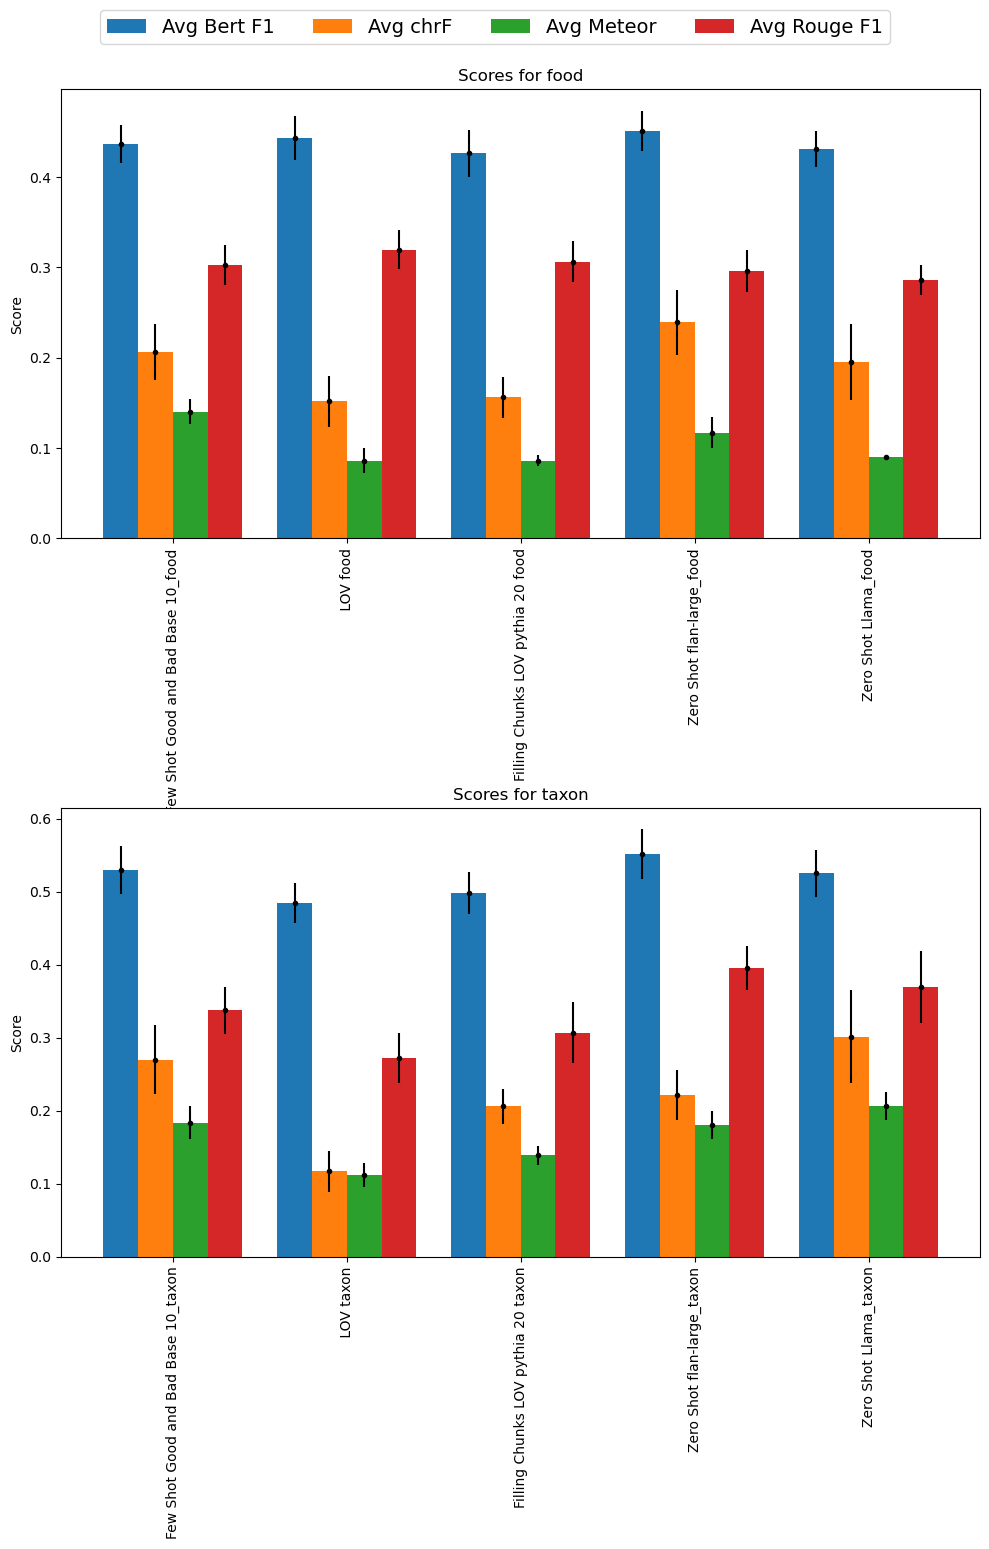

In [81]:
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

def produce_further_score_plot(input1, input2):
    df1 = further_metric_summaries[further_metric_summaries['Set'] == input1]
    df2 = further_metric_summaries[further_metric_summaries['Set'] == input2]
    
    # Extracting metrics for the first input
    bert_f1_avg1 = df1['Avg Bert F1']
    rouge_f1_avg1 = df1['Avg Rouge F1']
    meteor_avg1 = df1['Avg Meteor']
    chrf_avg1 = df1['Avg chrF'] / 100
    bert_f1_std1 = df1['Std Bert F1'].tolist()
    rouge_f1_std1 = df1['Rouge std F1'].tolist()
    meteor_std1 = df1['Std Meteor'].tolist()
    chrf_std1 = df1['Std chrF'].tolist()
    
    # Extracting metrics for the second input
    bert_f1_avg2 = df2['Avg Bert F1']
    rouge_f1_avg2 = df2['Avg Rouge F1']
    meteor_avg2 = df2['Avg Meteor']
    chrf_avg2 = df2['Avg chrF'] / 100
    bert_f1_std2 = df2['Std Bert F1'].tolist()
    rouge_f1_std2 = df2['Rouge std F1'].tolist()
    meteor_std2 = df2['Std Meteor'].tolist()
    chrf_std2 = df2['Std chrF'].tolist()
    
    x1 = np.arange(len(df1))
    x2 = np.arange(len(df2))
    width = 0.2

    fig, axes = plt.subplots(2, 1, figsize=(10, 15))  # Create a figure with 2 subplots stacked vertically
    
    # Plotting for the first input
    bar1 = axes[0].bar(x1 - 0.3, bert_f1_avg1, width, label='Bert F1')
    bar2 = axes[0].bar(x1 - 0.1, rouge_f1_avg1, width, label='Rouge F1')
    bar3 = axes[0].bar(x1 + 0.1, meteor_avg1, width, label='Meteor')
    bar4 = axes[0].bar(x1 + 0.3, chrf_avg1, width, label='chrF')
    axes[0].errorbar(x1 - 0.3, bert_f1_avg1, yerr=[x / sqrt(10) for x in bert_f1_std1], fmt='.', color='black')
    axes[0].errorbar(x1 - 0.1, rouge_f1_avg1, yerr=[x / sqrt(10) for x in rouge_f1_std1], fmt='.', color='black')
    axes[0].errorbar(x1 + 0.1, meteor_avg1, yerr=[x / sqrt(10) for x in meteor_std1], fmt='.', color='black')
    axes[0].errorbar(x1 + 0.3, chrf_avg1, yerr=[x / (100 * sqrt(10)) for x in chrf_std1], fmt='.', color='black')
    axes[0].set_xticks(x1)
    axes[0].set_xticklabels(df1['Type'].tolist(), rotation=90)
    axes[0].set_ylabel('Score')
    axes[0].set_title(f'Scores for {input1}')
    #axes[0].legend()

    # Plotting for the second input
    axes[1].bar(x2 - 0.3, bert_f1_avg2, width, label='Bert F1')
    axes[1].bar(x2 - 0.1, rouge_f1_avg2, width, label='Rouge F1')
    axes[1].bar(x2 + 0.1, meteor_avg2, width, label='Meteor')
    axes[1].bar(x2 + 0.3, chrf_avg2, width, label='chrF')
    axes[1].errorbar(x2 - 0.3, bert_f1_avg2, yerr=[x / sqrt(10) for x in bert_f1_std2], fmt='.', color='black')
    axes[1].errorbar(x2 - 0.1, rouge_f1_avg2, yerr=[x / sqrt(10) for x in rouge_f1_std2], fmt='.', color='black')
    axes[1].errorbar(x2 + 0.1, meteor_avg2, yerr=[x / sqrt(10) for x in meteor_std2], fmt='.', color='black')
    axes[1].errorbar(x2 + 0.3, chrf_avg2, yerr=[x / (100 * sqrt(10)) for x in chrf_std2], fmt='.', color='black')
    axes[1].set_xticks(x2)
    axes[1].set_xticklabels(df2['Type'].tolist(), rotation=90)
    axes[1].set_ylabel('Score')
    axes[1].set_title(f'Scores for {input2}')
   # axes[1].legend()
    handles = [bar1, bar2, bar3, bar4]
    labels = ['Avg Bert F1', 'Avg chrF', 'Avg Meteor', 'Avg Rouge F1']
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.6)  # Adjust space between subplots
    
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=4, fontsize = 14)

    plt.savefig(f'plots/further_results_{input1}_{input2}.png', bbox_inches='tight')
    plt.show()

    

# Example usage:
produce_further_score_plot('food', 'taxon')
